<a href="https://colab.research.google.com/github/aruaru0/yolov8-test/blob/main/YOLOv8_train_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
is_colab = False
if "google.colab" in sys.modules:
  is_colab = True

In [ ]:
if is_colab:
  from google.colab import drive
  drive.mount('/content/drive')

if is_colab:
  !mkdir -p /root/.kaggle
  !cp /content/drive/MyDrive/Kaggle/kaggle.json  /root/.kaggle/
  !chmod 600 /root/.kaggle/kaggle.json

if is_colab:
  !pip install kaggle
  !apt install unzip
  !mkdir input output

Mounted at /content/drive
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.1).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


In [ ]:
if is_colab:
  !kaggle datasets download -d sshikamaru/car-object-detection
  !unzip -o car-object-detection.zip -d input/car-object-detection

100% 112M/112M [00:03<00:00, 41.1MB/s]
100% 112M/112M [00:03<00:00, 34.3MB/s]
Archive:  car-object-detection.zip
  inflating: input/car-object-detection/data/sample_submission.csv  
  inflating: input/car-object-detection/data/testing_images/vid_5_25100.jpg  
  inflating: input/car-object-detection/data/testing_images/vid_5_25120.jpg  
  inflating: input/car-object-detection/data/testing_images/vid_5_25140.jpg  
  inflating: input/car-object-detection/data/testing_images/vid_5_25160.jpg  
  inflating: input/car-object-detection/data/testing_images/vid_5_25180.jpg  
  inflating: input/car-object-detection/data/testing_images/vid_5_25200.jpg  
  inflating: input/car-object-detection/data/testing_images/vid_5_25220.jpg  
  inflating: input/car-object-detection/data/testing_images/vid_5_25240.jpg  
  inflating: input/car-object-detection/data/testing_images/vid_5_25260.jpg  
  inflating: input/car-object-detection/data/testing_images/vid_5_26320.jpg  
  inflating: input/car-object-detectio

In [ ]:
%cd output

/content/output


In [ ]:
# install yolov8
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.5/616.5 kB 8.8 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
import os
import random
import shutil
import numpy as np
import pandas as pd
import cv2
import yaml
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split

In [ ]:
DIR = "./datasets/cars/"
IMAGES = DIR +"images/"
LABELS = DIR +"labels/"

TRAIN = "../input/car-object-detection/data/training_images"
TEST = "../input/car-object-detection/data/testing_images"

In [ ]:
df = pd.read_csv("../input/car-object-detection/data/train_solution_bounding_boxes (1).csv")
df

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422
...,...,...,...,...,...
554,vid_4_9860.jpg,0.000000,198.321729,49.235251,236.223284
555,vid_4_9880.jpg,329.876184,156.482351,536.664239,250.497895
556,vid_4_9900.jpg,0.000000,168.295823,141.797524,239.176652
557,vid_4_9960.jpg,487.428988,172.233646,616.917699,228.839864


In [ ]:
files = list(df.image.unique())

files_train, files_valid = train_test_split(files, test_size = 0.2)

In [ ]:
# make directories
os.makedirs(IMAGES+"train", exist_ok=True)
os.makedirs(LABELS+"train", exist_ok=True)
os.makedirs(IMAGES+"valid", exist_ok=True)
os.makedirs(LABELS+"valid", exist_ok=True)

In [ ]:
train_filename = set(files_train)
valid_filename = set(files_valid)
for file in glob.glob(TRAIN+"/*"):
    fname =os.path.basename(file)
    if fname in train_filename:
        shutil.copy(file, IMAGES+"train")
    elif fname in valid_filename:
        shutil.copy(file, IMAGES+"valid")

In [ ]:
for _, row in df.iterrows():
    image_file = row['image']
    class_id = "0"
    x = row['xmin']
    y = row['ymin']
    width = row['xmax'] - row['xmin']
    height = row['ymax'] - row['ymin']

    x_center = x + (width / 2)
    y_center = y + (height / 2)
    x_center /= 676
    y_center /= 380
    width /= 676
    height /= 380

    if image_file in train_filename:
        annotation_file = os.path.join(LABELS) + "train/" + image_file.replace('.jpg', '.txt')
    else:
        annotation_file = os.path.join(LABELS) + "valid/" + image_file.replace('.jpg', '.txt')

    with open(annotation_file, 'a') as ann_file:
        ann_file.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

In [ ]:
%%writefile dataset.yaml
# Path
path: ./cars
train: images/train
val: images/valid

# Classes
nc: 1
names: ['car']

Writing dataset.yaml


In [ ]:
# !pip insatall wandb

In [ ]:
# # disable wandb
# import wandb
# wandb.init(mode="disabled")

# TRAIN

In [ ]:
model = YOLO('yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 194MB/s]


In [ ]:
%%time
model.train(data="dataset.yaml", epochs=100, batch=8)

Ultralytics YOLOv8.0.192 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset.yaml, epochs=100, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int

CPU times: user 6min 10s, sys: 31.4 s, total: 6min 42s
Wall time: 6min 25s


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f73102253f0>
fitness: 0.7328217220736568
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.70521])
names: {0: 'car'}
plot: True
results_dict: {'metrics/precision(B)': 0.9648879526941939, 'metrics/recall(B)': 0.9992877422877423, 'metrics/mAP50(B)': 0.9813571340807752, 'metrics/mAP50-95(B)': 0.7052066762950882, 'fitness': 0.7328217220736568}
save_dir: PosixPath('runs/detect/train')
speed: {'preprocess': 0.6507248945639167, 'inference': 1.4027239571154957, 'loss': 0.0009100202103735695, 'postprocess': 0.6409094367228764}

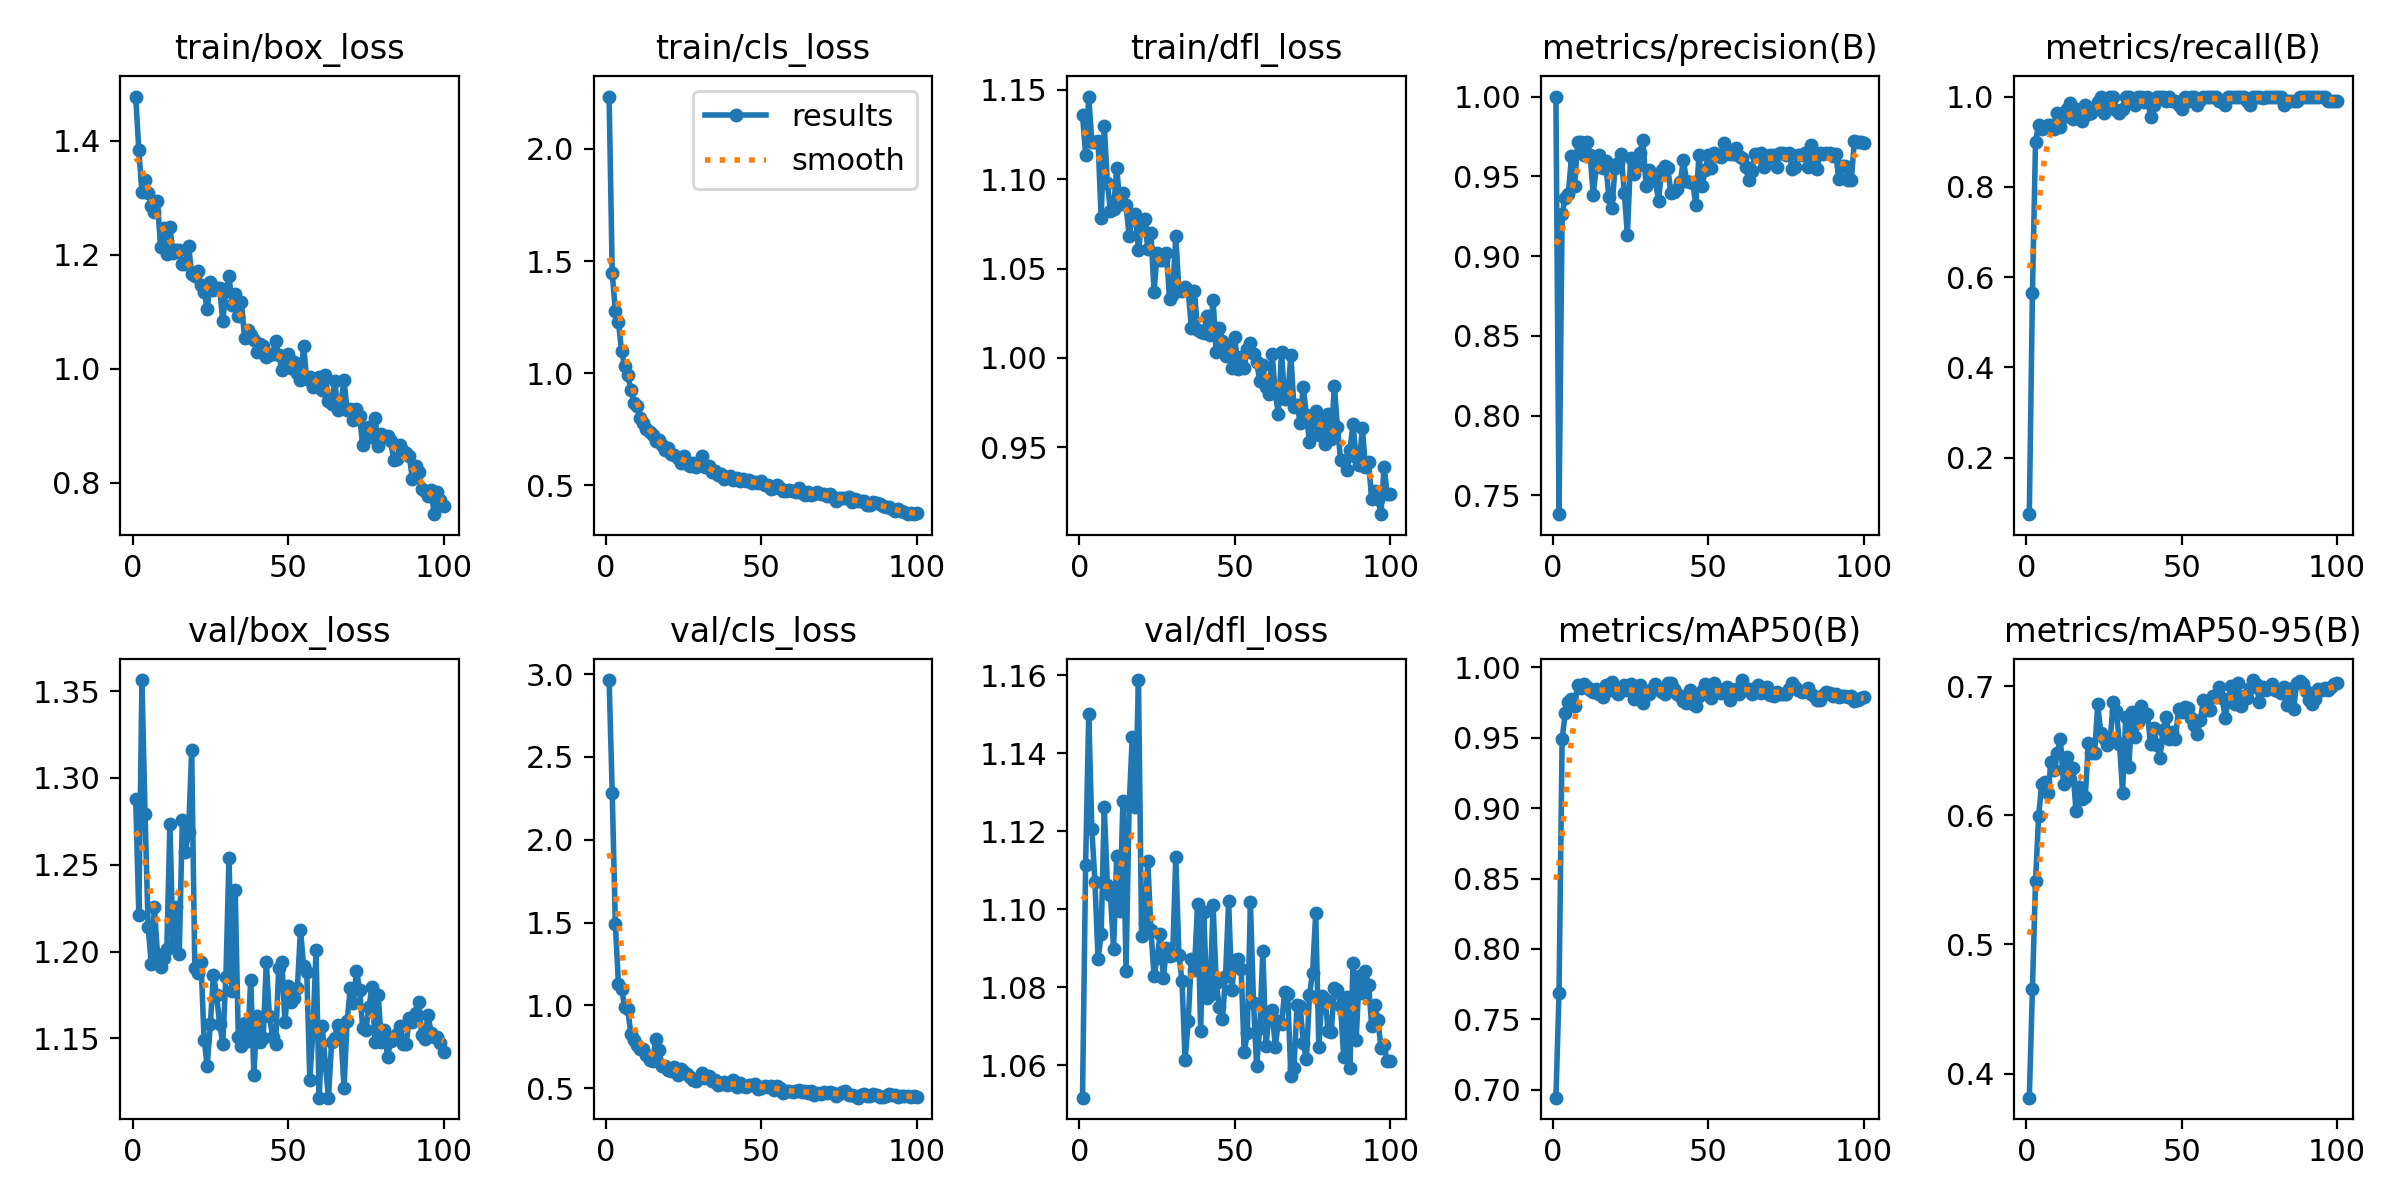

In [ ]:
from IPython.display import Image

Image("./runs/detect/train/results.png")

# Inference

In [ ]:
model = YOLO('./runs/detect/train/weights/last.pt')
ret = model("../input/car-object-detection/data/testing_images",save=True, conf=0.2, iou=0.5)


image 1/175 /content/output/../input/car-object-detection/data/testing_images/vid_5_25100.jpg: 384x640 (no detections), 60.3ms
image 2/175 /content/output/../input/car-object-detection/data/testing_images/vid_5_25120.jpg: 384x640 (no detections), 5.8ms
image 3/175 /content/output/../input/car-object-detection/data/testing_images/vid_5_25140.jpg: 384x640 (no detections), 5.8ms
image 4/175 /content/output/../input/car-object-detection/data/testing_images/vid_5_25160.jpg: 384x640 (no detections), 6.1ms
image 5/175 /content/output/../input/car-object-detection/data/testing_images/vid_5_25180.jpg: 384x640 (no detections), 5.9ms
image 6/175 /content/output/../input/car-object-detection/data/testing_images/vid_5_25200.jpg: 384x640 (no detections), 5.7ms
image 7/175 /content/output/../input/car-object-detection/data/testing_images/vid_5_25220.jpg: 384x640 (no detections), 5.7ms
image 8/175 /content/output/../input/car-object-detection/data/testing_images/vid_5_25240.jpg: 384x640 (no detection

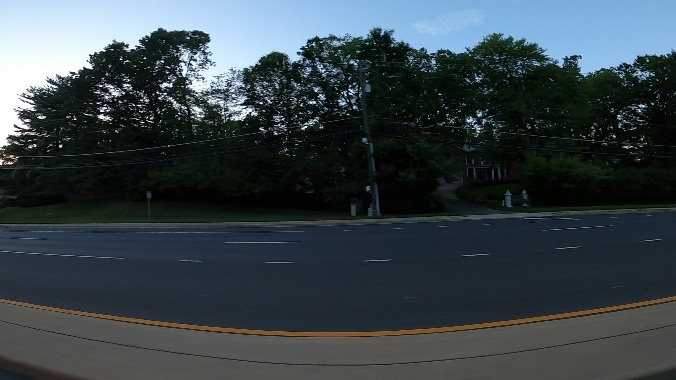

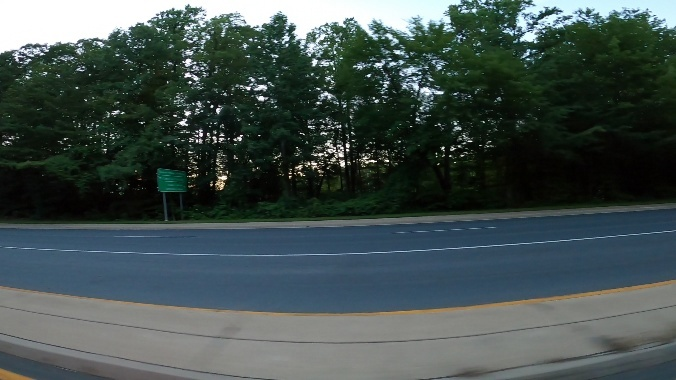

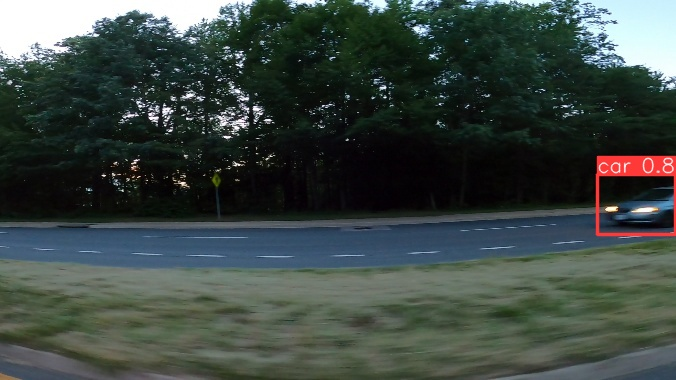

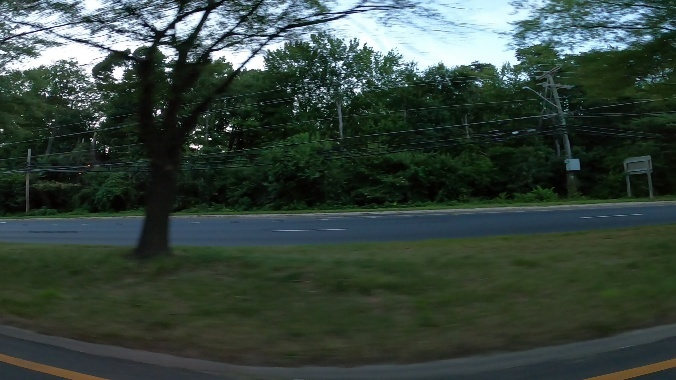

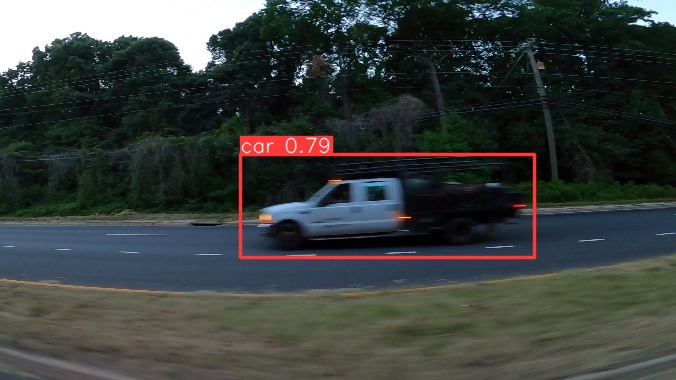

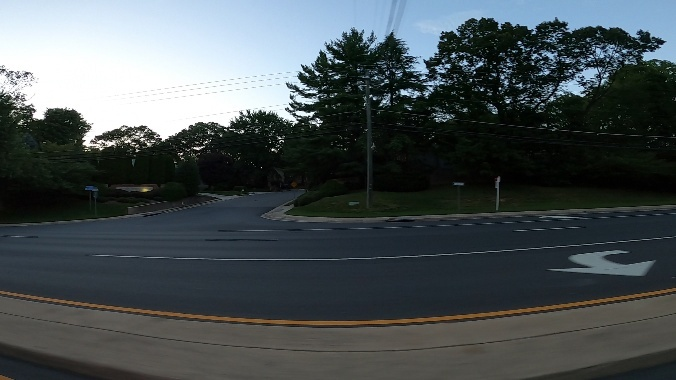

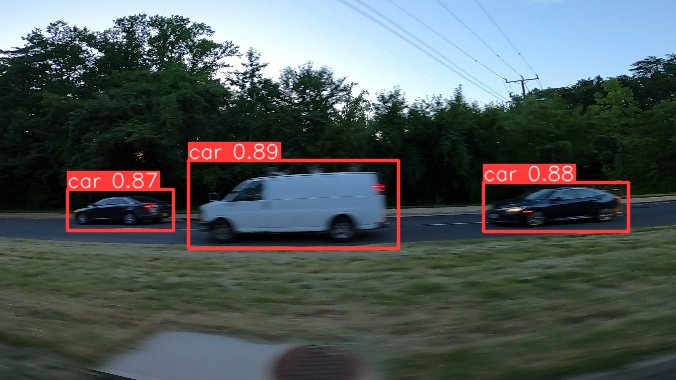

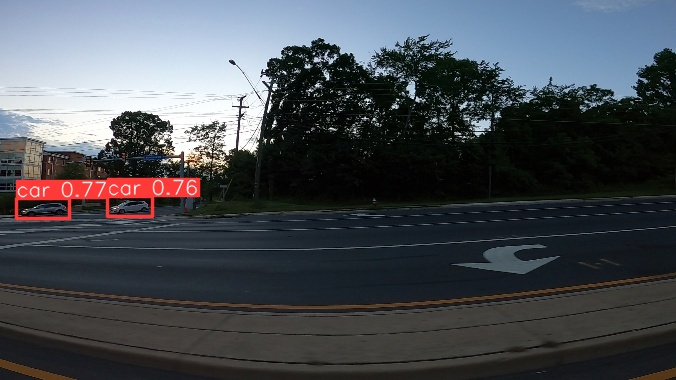

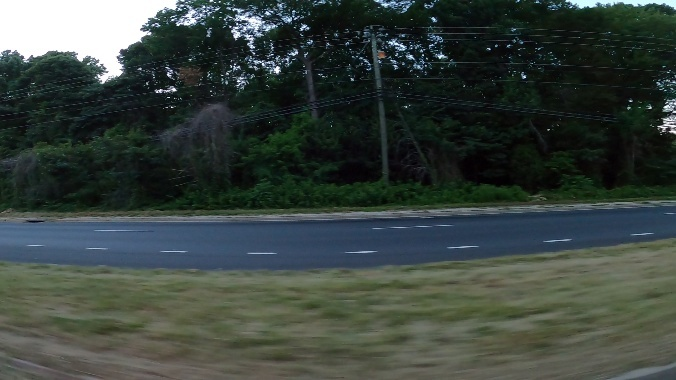

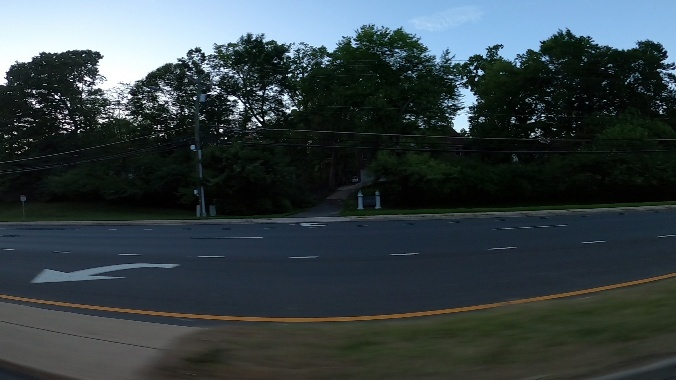

In [ ]:
# display result
files = glob.glob("./runs/detect/predict/*")
for i in range(0, 30, 3):
    img = Image(files[i])
    display(img)